#1. Entendimiento de los datos#

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/BI/Lab3/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/BI/Lab3


Para empezar con el entendimiento de los datos lo primero que hicimos fué importar todas las librerias necesarias y cargar el data frame utilizando pandas, a continuación se mostrará la carga de los datos y una muestra de 5 elementos aleatorios del dataframe

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import train_test_split
from joblib import dump, load
df = pd.read_csv('202220_Laboratorio_3_data_university_admission_train.csv', sep=',')
df.drop(["Unnamed: 0"], axis = 1, inplace=True)
df.sample(10)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admission Points
947,372,324,71,3,4.98,4.05,9.22,1,89.00
436,79,294,93,1,2.11,2.00,7.43,0,45.00
974,496,274,99,4,4.50,4.01,9.02,0,85.47
585,107,329,96,4,4.50,4.50,8.39,1,87.00
1276,17,317,107,3,4.00,2.31,8.35,0,NaN
386,423,322,112,4,3.50,2.53,9.02,1,73.00
864,347,275,94,1,1.28,1.55,8.48,0,45.32
312,378,312,97,2,2.00,2.76,9.69,0,49.27
218,394,290,109,3,3.53,3.50,9.12,1,126.00
1300,384,300,99,2,3.30,3.20,8.35,0,40.82


In [ ]:
df.shape

(1569, 9)

A continuación se realizará una busqueda de valores nulos para despues tomar decisones en la preparación de los datos

In [ ]:
df.isnull().sum()

Serial No.            0
GRE Score             0
TOEFL Score           0
University Rating     0
SOP                   0
LOR                   0
CGPA                  0
Research              0
Admission Points     65
dtype: int64

In [ ]:
df = df.dropna()
df.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Admission Points     0
dtype: int64

In [ ]:
df.shape

(1504, 9)

In [ ]:
df['Admission Points'].describe

<bound method NDFrame.describe of 0       84.47
1       45.08
2       47.42
3       62.00
4       73.00
        ...  
1564    47.50
1565    52.00
1566    47.54
1567    64.00
1568    72.00
Name: Admission Points, Length: 1504, dtype: float64>

In [ ]:
df.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Admission Points     float64
dtype: object

#2. Identificación de variables a utilizar#

##Relaciones con la variable objetivo##

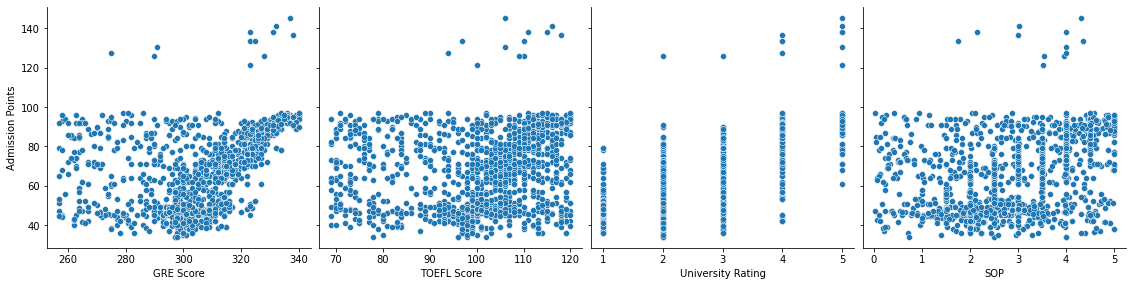

In [ ]:
features = ['GRE Score','TOEFL Score','University Rating','SOP','LOR ','CGPA','Research']
sns.pairplot(df.sample(1500), height = 4, y_vars = 'Admission Points', x_vars = features[:4], kind = 'scatter')

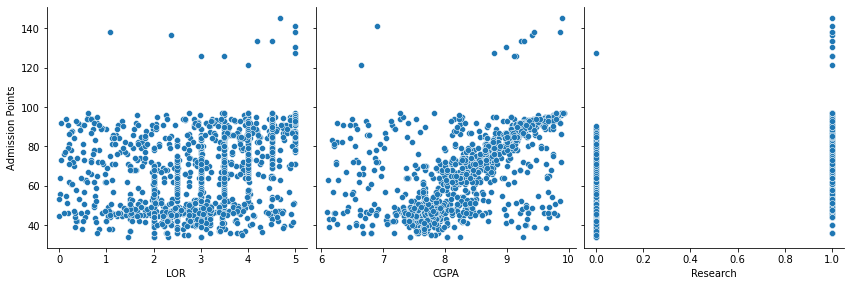

In [ ]:
sns.pairplot(df.sample(1500), height = 4, y_vars = 'Admission Points', x_vars = features[4:], kind = 'scatter')

##Relación entre atributos y variable predicción##

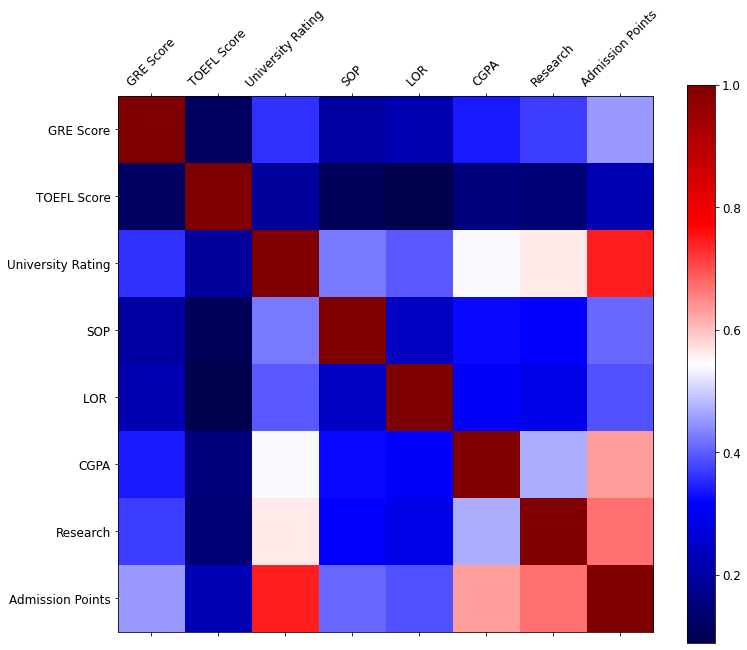

In [ ]:
f = plt.figure(figsize = (12, 10))
ft = features+["Admission Points"]
plt.matshow(df[ft].corr(), fignum=f.number, cmap = 'seismic')
plt.xticks(range(len(ft)), ft, fontsize = 12, rotation = 45)
plt.yticks(range(len(ft)), ft, fontsize = 12)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize = 12)

### Proceso de elección de variables:

Se busca elegir las features con mayor correlación con los puntos de admisión. Dadas la escala de la gráfica anterior, se puede evidenciar que aquellos features con una tonalidad de azul más oscura, tienen una correlación muy proxima a 0, lo cual proporciona indicios de que estas variables podrían ser omitidas en el entrenamiento del modelo. Así mismo, se compara con las gráficas de relación por cada feature presentadas y se corrobora la decisión. Las columnas que no se tendrán en cuenta serán "TOEFL Score" y "LOR "

In [ ]:
features = [elem for elem in features if elem not in [ "TOEFL Score", "LOR "] ]

#3. Preparación de datos#

In [ ]:
Y = df['Admission Points']
X = df.drop(['Admission Points'], axis=1)

scaler = StandardScaler()
normal = Normalizer()
X = scaler.fit_transform(X)
X = pd.DataFrame(normal.fit_transform(X))
X.columns = df.drop(['Admission Points'], axis=1).columns

X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size = 0.15, random_state = 1)

#4. Modelamiento#

Se define el PipeLine que se empleará. Se ejecuta primero la clase de ColumnTransformer de sklearn.compose que es la que permite la elección de las features que se considerarán en la predicción. Posteriormente, se somete el modelo a la clase LinearRegresion de sklearn.linear_models para hacer llamado al modelo que se usará.

In [ ]:
pipeline = Pipeline(
    [
        ('feature_selection', ColumnTransformer(
            [
                ('selector', 'passthrough', features)
            ]
        )),
        ('model', LinearRegression())
    ]
)

Se procede a realizar el ajuste del modelo lineal con los datos de entrenamiento.

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_selection',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['GRE Score',
                                                   'University Rating', 'SOP',
                                                   'CGPA', 'Research'])])),
                ('model', LinearRegression())])

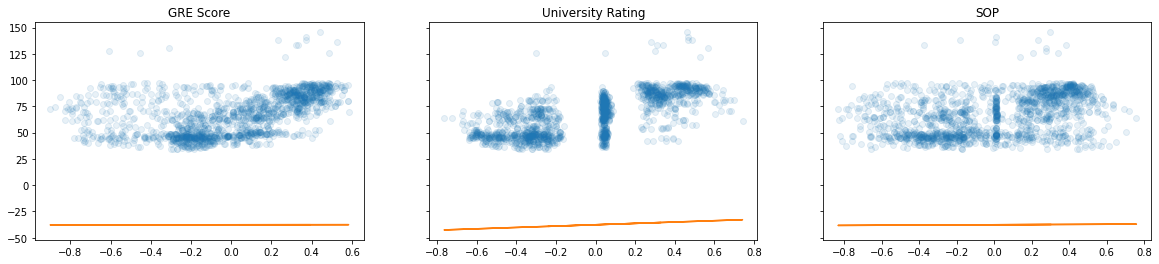

In [ ]:
f, axs = plt.subplots(1, len(features)-2, sharey = True, figsize = (20, 4))

for i in range(len(features)-2):
    col = features[i]
    x = X[col]
    m = pipeline['model'].coef_[i]
    b = pipeline['model'].intercept_

    axs[i].plot(x, df['Admission Points'], 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

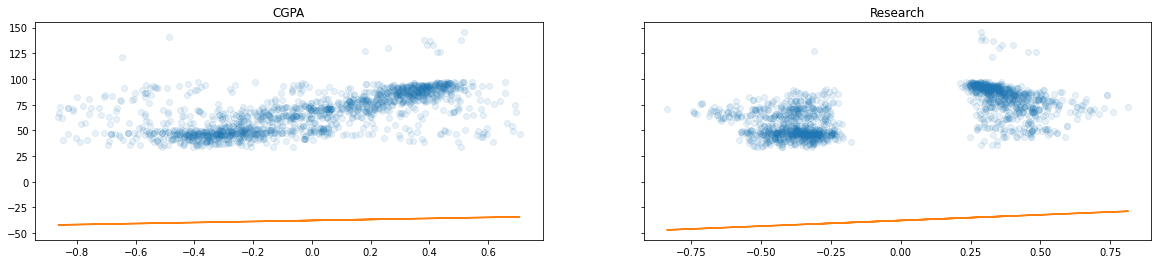

In [ ]:
f, axs = plt.subplots(1, len(features)-3, sharey = True, figsize = (20, 4))

for i in range(len(features)-3):
    col = features[i+3]
    x = X[col]
    m = pipeline['model'].coef_[i+3]
    b = pipeline['model'].intercept_

    axs[i].plot(x, df['Admission Points'], 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

#5. Evaluación cuantitativa#

### Calculo del MAE (error absoluto medio):

#### MAE Para datos de entrenamiento

In [ ]:
mean_absolute_error(y_train, pipeline.predict(X_train))

7.926719118862385

#### MAE Para datos de prueba

In [ ]:
mean_absolute_error(y_test, pipeline.predict(X_test))

7.224313299656155

In [ ]:
df['Admission Points'].describe()

count    1504.000000
mean       66.744328
std        19.253029
min        34.000000
25%        48.000000
50%        67.000000
75%        84.000000
max       145.500000
Name: Admission Points, dtype: float64

### Calculo del RMSE (raíz del error cuadratico medio):

#### RMSE Para datos de entrenamiento

In [ ]:
np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))

10.633077611404092

#### RMSE Para datos de prueba

In [ ]:
np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test)))

9.582047081615375

### **Conclusión cuantitativa:**

**¿Se recomienda instalar el modelo de estimación en producción?** 

En principio, se le recomienda a la empresa que se emplee el modelo de estimación como un mecanismo de ayuda para el proceso de selección, más no como una herramienta que determine directamente si un estudiante es admitido o no. Así pues, su finalidad podría ser de corte preliminar para disminuir la cantidad de candidatos inicial.

Lo anterior se estableció a partir de las metricas obtenidas. Especificamente, al observar el valor obtenido en el MSE, se puede observar como el promedio de la diferencia entre la predcción y los datos reales tiene un valor de 7.4 puntos. Dados los objetivos de la Universidad, y que es un proceso critico, se podría decir que ese intervalo de  [-7.4;7.4] de posible error en los puntos, puede ser determinante en la decisión final para un admitido.





**¿Qué otras posibilidades se recomiendan? ¿Hacia dónde debe seguir con esta tarea?**

Se le recomienda a la empresa, por un lado, considerar modelos de predicción con una mayor complejidad, para ello, podrían optar por implementar modelos basados en polinomios de un orden mayor, pues se identificaron algunos comportamientos no lineales en la comparación gráfica de los features contra el label de predicción. 

Así mismo, se podría pensar en implementar un modelo basado en redes neuronales, en el cual se ajusten adecuadamente los parametros correspondientes al tamaño y profundidad de la red.  

Por el otro lado, otra posible mejora podría ser aumentar los datos de entrenamiento a partir de un historico mayor, o aumentando el actual a través del tiempo, y, además, considerar añadir más caracteristicas relevantes acerca de los admitidos. 


#6. Evaluación cualitativa#

In [ ]:
pd.DataFrame({'columns':features, 'coef':pipeline['model'].coef_}).sort_values(by=["coef"],ascending=False)

,columns,coef
4,Research,11.000804
1,University Rating,6.436284
3,CGPA,4.987521
2,SOP,0.770612
0,GRE Score,0.119906


### **Conclusión cualitativa:**

A partir del ejercicio de regresión, se obtuvo no solo una herramienta de predicción para determinar que tan posible es que alguien sea admitido, sino que tambien se obtuvieron valores de los coeficientes o pesos de cada feature, los cuales serán utiles para el objetivo de la empresa a la hora de determinar de forma manual la admisión. 

En este orden de ideas, la tabla presentada, permite evidenciar los pesos o importancia de cada variable frente al calculo de la decisión del modelo de regresión (teniendo en cuenta que se encuentra escalado). 

Las variables más relevantes serían el Research, el University Rating y el CGPA. Mientras que las dos con menor relevancia en la elección serían el GRE Score y SOP. 

Cabe resaltar, que el más importante de todos es Research, el cual tiene un peso casi igual a la suma del resto de pesos de los feauters. Por lo tanto, se le recomendaría a la Universidad hacer incapie en dicha caracteristica a la hora de la elección.

###Evaluación visual

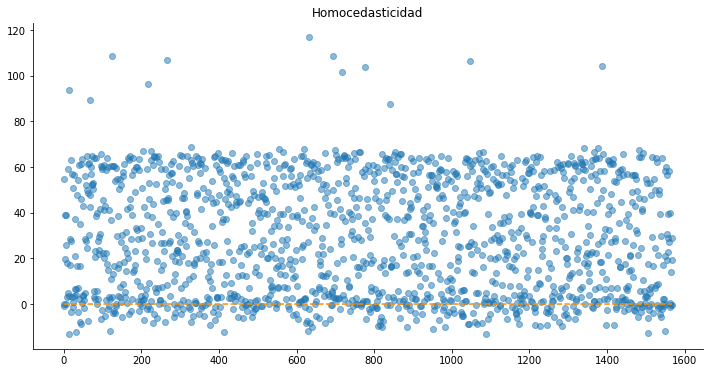

In [ ]:
predictions = pipeline.predict(X)
df_results = pd.DataFrame({'Actual': Y, 'Predicted': predictions})
df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])

   # Plotting the residuals
plt.subplots(figsize=(12, 6))
ax = plt.subplot(111)  # To remove spines
plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
ax.spines['right'].set_visible(False)  # Removing the right spine
ax.spines['top'].set_visible(False)  # Removing the top spine
plt.title('Homocedasticidad')
plt.show()  

Como podemos ver, la varianza en los errores se mantiene constante a medida que varía la variable objetivo.

## EXPORTACIÓN DEL MODELO


In [ ]:
# Nombre del archivo
filename = 'modelo.joblib'
# Se guarda
dump(pipeline, filename) 

['modelo.joblib']